Define headers

In [1]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
# from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

Define Dataset

In [2]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import cv2
from PIL import Image

def get_ball_dicts():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4:69+4]
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Ball/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

def get_ball_dicts_grayscale():
    txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "open_images_grayscale.txt")
    f = open(txt_file, "r")
    c=0
    dataset_dicts = []
    
    for line in f:
        record = {}
        objs = []
        c+=1

        filename=line[49+4+1:69+4+1]
#         print(filename)
        width, height = Image.open(os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)).size

        record["file_name"] = os.path.join("/home/danielarato/ball_detection/Datasets/train/Grayscale/", filename)
        record["image_id"] = c
        record["height"] = height
        record["width"] = width

        label_txt="/home/danielarato/ball_detection/Datasets/train/Label/"+filename[:16]+".txt"
        f_label = open(label_txt, "r")

        for line_label in f_label:
            px=[]
            py=[]
#             print(line_label)
            x = line_label.split()
#             print(x)
            px.append(float(x[1]))
            px.append(float(x[3]))
            py.append(float(x[2]))
            py.append(float(x[4]))
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": 0,
                "iscrowd": 0
            }
            objs.append(obj)    
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.register("Ball_train", lambda:get_ball_dicts())
MetadataCatalog.get("Ball_train").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train")


DatasetCatalog.register("Ball_train_bw", lambda:get_ball_dicts_grayscale())
MetadataCatalog.get("Ball_train_bw").set(thing_classes=["Ball"])
ball_metadata = MetadataCatalog.get("Ball_train_bw")

Confirm if datasets works

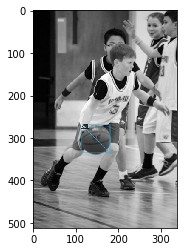

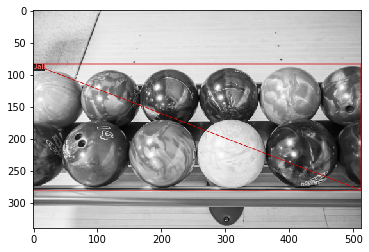

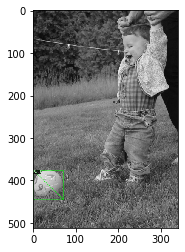

In [3]:
import random 
import matplotlib.pyplot as plt
dataset_dicts = get_ball_dicts_grayscale()
ball_metadata = MetadataCatalog.get("Ball_train_bw")
# print (dataset_dicts)
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=ball_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.figure()
    plt.imshow(vis.get_image()[:, :, ::-1])
    


In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import torch
torch.cuda.set_device(2)
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("Ball_train_bw",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_C4_1x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 2000    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[01/23 10:39:37 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

[01/23 10:39:37 d2.data.build]: Removed 0 images with no usable annotations. 3480 images left.
[01/23 10:39:37 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    Ball    | 6845         |
|            |              |
[01/23 10:39:37 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[01/23 10:39:37 d2.data.build]: Using training sampler TrainingSampler


'roi_heads.box_predictor.cls_score.weight' has shape (81, 2048) in the checkpoint but (2, 2048) in the model! Skipped.
'roi_heads.box_predictor.cls_score.bias' has shape (81,) in the checkpoint but (2,) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.weight' has shape (320, 2048) in the checkpoint but (4, 2048) in the model! Skipped.
'roi_heads.box_predictor.bbox_pred.bias' has shape (320,) in the checkpoint but (4,) in the model! Skipped.


[01/23 10:39:38 d2.engine.train_loop]: Starting training from iteration 0
[01/23 10:39:43 d2.utils.events]: eta: 0:07:32  iter: 19  total_loss: 1.427  loss_cls: 0.690  loss_box_reg: 0.511  loss_rpn_cls: 0.214  loss_rpn_loc: 0.018  time: 0.2305  data_time: 0.0123  lr: 0.000005  max_mem: 2115M
[01/23 10:39:47 d2.utils.events]: eta: 0:07:39  iter: 39  total_loss: 1.331  loss_cls: 0.670  loss_box_reg: 0.435  loss_rpn_cls: 0.205  loss_rpn_loc: 0.005  time: 0.2340  data_time: 0.0061  lr: 0.000010  max_mem: 2115M
[01/23 10:39:52 d2.utils.events]: eta: 0:07:33  iter: 59  total_loss: 1.106  loss_cls: 0.571  loss_box_reg: 0.362  loss_rpn_cls: 0.159  loss_rpn_loc: 0.005  time: 0.2335  data_time: 0.0056  lr: 0.000015  max_mem: 2115M
[01/23 10:39:58 d2.utils.events]: eta: 0:07:33  iter: 79  total_loss: 1.123  loss_cls: 0.469  loss_box_reg: 0.359  loss_rpn_cls: 0.217  loss_rpn_loc: 0.007  time: 0.2356  data_time: 0.0054  lr: 0.000020  max_mem: 2115M
[01/23 10:40:03 d2.utils.events]: eta: 0:07:31  it

[01/23 10:42:51 d2.utils.events]: eta: 0:05:12  iter: 739  total_loss: 0.276  loss_cls: 0.053  loss_box_reg: 0.144  loss_rpn_cls: 0.047  loss_rpn_loc: 0.004  time: 0.2467  data_time: 0.0066  lr: 0.000185  max_mem: 2123M
[01/23 10:42:56 d2.utils.events]: eta: 0:05:07  iter: 759  total_loss: 0.261  loss_cls: 0.050  loss_box_reg: 0.145  loss_rpn_cls: 0.042  loss_rpn_loc: 0.005  time: 0.2467  data_time: 0.0064  lr: 0.000190  max_mem: 2123M
[01/23 10:43:01 d2.utils.events]: eta: 0:05:02  iter: 779  total_loss: 0.301  loss_cls: 0.049  loss_box_reg: 0.144  loss_rpn_cls: 0.042  loss_rpn_loc: 0.009  time: 0.2467  data_time: 0.0065  lr: 0.000195  max_mem: 2123M
[01/23 10:43:06 d2.utils.events]: eta: 0:04:58  iter: 799  total_loss: 0.355  loss_cls: 0.082  loss_box_reg: 0.163  loss_rpn_cls: 0.035  loss_rpn_loc: 0.007  time: 0.2468  data_time: 0.0065  lr: 0.000200  max_mem: 2123M
[01/23 10:43:11 d2.utils.events]: eta: 0:04:53  iter: 819  total_loss: 0.334  loss_cls: 0.080  loss_box_reg: 0.180  loss

[01/23 10:45:56 d2.utils.events]: eta: 0:02:16  iter: 1459  total_loss: 0.292  loss_cls: 0.084  loss_box_reg: 0.157  loss_rpn_cls: 0.032  loss_rpn_loc: 0.016  time: 0.2487  data_time: 0.0064  lr: 0.000250  max_mem: 2123M
[01/23 10:46:02 d2.utils.events]: eta: 0:02:11  iter: 1479  total_loss: 0.225  loss_cls: 0.054  loss_box_reg: 0.138  loss_rpn_cls: 0.035  loss_rpn_loc: 0.004  time: 0.2487  data_time: 0.0070  lr: 0.000250  max_mem: 2123M
[01/23 10:46:07 d2.utils.events]: eta: 0:02:06  iter: 1499  total_loss: 0.269  loss_cls: 0.049  loss_box_reg: 0.165  loss_rpn_cls: 0.026  loss_rpn_loc: 0.010  time: 0.2488  data_time: 0.0065  lr: 0.000250  max_mem: 2123M
[01/23 10:46:13 d2.utils.events]: eta: 0:02:01  iter: 1519  total_loss: 0.236  loss_cls: 0.061  loss_box_reg: 0.163  loss_rpn_cls: 0.022  loss_rpn_loc: 0.003  time: 0.2488  data_time: 0.0062  lr: 0.000250  max_mem: 2123M
[01/23 10:46:18 d2.utils.events]: eta: 0:01:55  iter: 1539  total_loss: 0.190  loss_cls: 0.034  loss_box_reg: 0.117 

OrderedDict()

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("ball_train", )
predictor = DefaultPredictor(cfg)

tensor([0.7004], device='cuda:2') Boxes(tensor([[242.1105,  68.5178, 251.0110,  75.9402]], device='cuda:2'))
0.7003936


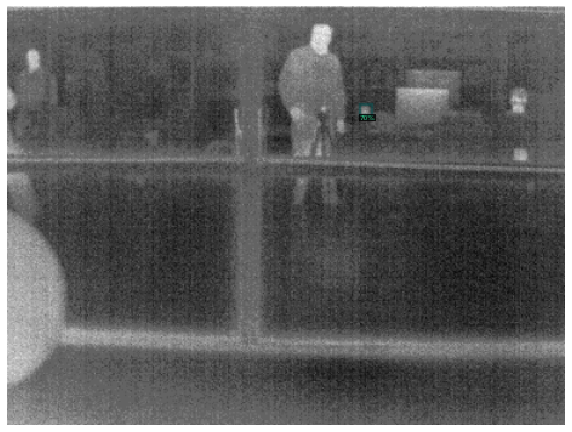

In [50]:
im = cv2.imread("/home/danielarato/ball_detection/Datasets/train/bag_2cam/thermic/1579790238028925357.png")

outputs = predictor(im)
print(outputs["instances"].scores, outputs["instances"].pred_boxes)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])

results=outputs["instances"].to("cpu")
results.pred_boxes.tensor[0].numpy()

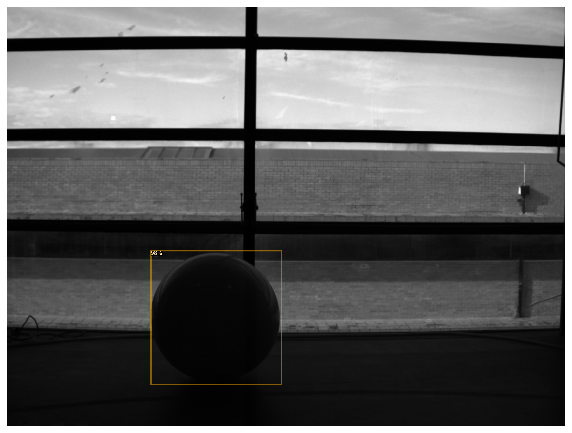

In [10]:
im_rgb = cv2.imread("/home/danielarato/ball_detection/Datasets/train/bag_2cam/RGB/1579790235832626993.png")

outputs2 = predictor(im_rgb)

v = Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs2["instances"].to("cpu"))
_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')
ax.imshow(v.get_image()[:, :, ::-1])

In [11]:
# cameraMatrix=[[708.30536, 0, 170.51079],
#  [0, 714.59424, 130.0705],
#  [0, 0, 1]]
from detectron2.utils.visualizer import ColorMode
import numpy as np
import time

d_real=0.63 *1000#m

cameraMatrix_IR=np.array([[725.790155, 0, 191.397201],
[0, 733.580771, 149.464123],
[0, 0, 1]])

print(cameraMatrix_IR)

fx=cameraMatrix_IR[0][0]
fy=cameraMatrix_IR[1][1]
cx=cameraMatrix_IR[0][2]
cy=cameraMatrix_IR[1][2]
print(fx,fy,cx,cy)

[[725.790155   0.       191.397201]
 [  0.       733.580771 149.464123]
 [  0.         0.         1.      ]]
725.790155 733.580771 191.397201 149.464123


In [12]:

cameraMatrix_RGB=np.array([[2168.684845,0,965.374725],
[0,2180.313918,699.133011],
[0,0,1]])

print(cameraMatrix_RGB)

fx_rgb=cameraMatrix_RGB[0][0]
fy_rgb=cameraMatrix_RGB[1][1]
cx_rgb=cameraMatrix_RGB[0][2]
cy_rgb=cameraMatrix_RGB[1][2]
print(fx_rgb,fy_rgb,cx_rgb,cy_rgb)

[[2.16868485e+03 0.00000000e+00 9.65374725e+02]
 [0.00000000e+00 2.18031392e+03 6.99133011e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
2168.684845 2180.313918 965.374725 699.133011


In [53]:
txt_file = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "IR_camera.txt")
f = open(txt_file, "r")
txt_result = open(os.path.join("/home/danielarato/ball_detection/Datasets/train/", "results_ir.txt"),"w") 
centers=diameters=[]


for line in f: 
# READ IMAGES CORRESPONDENT TO EACH LINE
    im = cv2.imread(line[:88])
    outputs = predictor(im)
    
    results=outputs["instances"].to("cpu")


# UNCOMENT TO VISUALIZE IMAGES
#     v= Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v = v.draw_instance_predictions(results)
#     plt.figure()
#     plt.imshow(v.get_image()[:, :, ::-1])
#     print(results.scores,results.pred_boxes)

# CALCULATE CENTERS
    if(len(results)!=0 and results.scores.numpy()[0]>0.85):
        
        coordinates=results.pred_boxes.tensor[0].numpy()
#         print(coordinates)
        xc=(coordinates[0]+coordinates[2])/2+coordinates[0]
        yc=(coordinates[3]+coordinates[1])/2+coordinates[1]
        xc=float("%0.2f"%xc)
        yc=float("%0.2f"%yc)
        centers.append([xc,yc])
        
        dx=float("%0.2f"%(float("%0.2f"%coordinates[2])-float("%0.2f"%coordinates[0])))
        dy=float("%0.2f"%(float("%0.2f"%coordinates[3])-float("%0.2f"%coordinates[1])))
        d_pix=(dx+dy)/2
        diameters.append([dx,dy]) 
        
        Z=((fx+fy)/2)*(d_real/d_pix)
        X=(Z*(xc-cx))/fx
        Y=(Z*(yc-cy))/fy
        
        
        txt_result.write(line[:88])
        txt_result.write(" , ")
        txt_result.write(np.array2string(coordinates))
        txt_result.write("\n")
        print(X/1000,Y/1000,Z/1000)
#         print("X1=",float("%0.2f"%coordinates[0]), " y1=",float("%0.2f"%coordinates[1])," x2=", float("%0.2f"%coordinates[2]), " y2=",float("%0.2f"%coordinates[3]),"Cx=",cx," Cy=",cy, " Dx=",dx," Dy=", dy)
txt_result.close()
f.close()

    

0.10144263081893341 0.820116624147596 3.07379787830564
0.0755601670215143 0.8522464407488515 3.1458416594128518
-0.039256207280084526 0.8263524955292408 3.1046251211589113
-0.022047885787885965 0.8011992458905511 3.0730786930276084
-0.1450834370346644 0.8094570539737813 3.0675419837848654
-0.1612170091537842 0.8179812584193835 3.1006464433427765
-0.1636972904503908 0.8128079917800088 3.114511122560976
-0.3100305252402499 0.838839230948268 3.1742980368043088
-0.33828042957580523 0.8168276793582698 3.0771928622397753
-0.4691258099340711 0.8234473137866684 3.1189486511296565
-0.4689462682749943 0.8262890432785668 3.0928236397214657
-0.5791126273447711 0.8553130923278067 3.3300868679778337
-0.5875529212327016 0.8593265282005248 3.3605164054972767
-0.5953806676816534 0.8788341477023535 3.3850141135451564
-0.6932479968956857 0.931553018977967 3.644522469496968
-0.7133176307078217 0.9567015194015115 3.7185184363195147
-0.8659335814507906 1.052499620687119 4.13512495898174
-0.8781066805732638 

21.647878672010478 -0.5319818562291099 52.77862705970149
17.073489388443917 -0.4628815070914912 41.84814216568048
18.037236363224373 -0.513731828196539 44.15963897118156
19.898132413486255 -0.6070550524011512 48.59427502008457
19.05549311506367 -0.547910258433635 46.55208523443038
19.450904523317543 -0.5049551261570342 47.46534245637584
19.20207464449178 -0.4551402399528584 46.93229624196019
19.514888309637737 -0.5652310498846098 47.63749654818653
19.4142961018561 -0.5487507364251037 47.39194244226805
19.2946455014312 -0.5217283981065766 47.05238911873081
18.771234946115108 -0.45674435389642215 45.809849695067264
21.490283938122126 -0.48657933082496924 52.537353336
18.37007967727288 -0.5114701343777863 44.80524772807017
18.0990383480334 -0.46481648782454943 44.20210016250001
17.711548200046387 -0.49778560244876785 43.347651267326725
21.26223182322448 -0.6159894166313701 51.85581970558376
19.748533725831056 -0.4856983194712314 48.18677585849058
21.226681997272642 -0.5202663276892551 51.

0.5354849453125413 1.7071119323158364 3.049585081574729
0.47626712599716753 1.710560315293913 3.045788186102094
0.418169699500449 1.6904488568858593 3.0175435810150004
0.35115059546033933 1.6819189252622757 3.006748190037751
0.28287944434469564 1.6826497987308624 3.0048026723073376
0.21469260795071485 1.6906343406565292 3.016812619125743
0.1326279749851572 1.6939779062021094 3.0084980078070953
0.04244376808904757 1.6810677541652712 2.989002586254295
-0.03317266363212041 1.7040308545611127 3.0387281325237057
-0.1206124514503672 1.6971257002129252 3.0164472709647585
-0.20840343854931187 1.6414982614963816 2.9389224373732925
-0.3102337722226348 1.6838028783937466 3.009819974173633
-0.3914507259222159 1.6988509728995191 3.029689299035761
-0.476861427696491 1.6489322589375794 2.974852847080922
-0.5779858085896483 1.6870985163088565 3.047617651097862
-0.6786460413572867 1.672482659072807 3.024071456137833
-0.7621492494189739 1.6813289248182663 3.0566957334634908
-0.8490723926354576 1.6771324

-0.8163213825577493 1.7172565683935543 3.209442796202368
-0.7567323412293291 1.7285871877032213 3.2003331550366765
-0.6817645322999573 1.7055549939116263 3.176328523041074
-0.6114560211732153 1.744878658541867 3.187673609328462
-0.5383710844065587 1.7158127407393922 3.1845243566023913
-0.45066188365641924 1.8007120033254942 3.2272102388602923
-0.08359446905676929 1.7265248147326069 3.1619591472573885
0.3407961026829892 1.7188840741943223 3.0951629790558166
0.7603851199748468 1.6869906807794006 3.0673725923782227
1.162455192081897 1.7253289997759365 3.127847413911594
1.5480267952822757 1.7191904367111654 3.1170298301365182
1.9284217902593068 1.7230927158726768 3.123247900473069
2.315094257084841 1.7506112738215023 3.158423503354544
2.704509271460697 1.736465507488389 3.165063905794422
3.078466195584375 1.7595353715521833 3.167185948918019
3.680017715898034 1.89512621064318 3.4329038499097875
4.63568791676944 2.252780807692066 4.017521365274641
6.616280182758781 2.952311079834273 5.34056

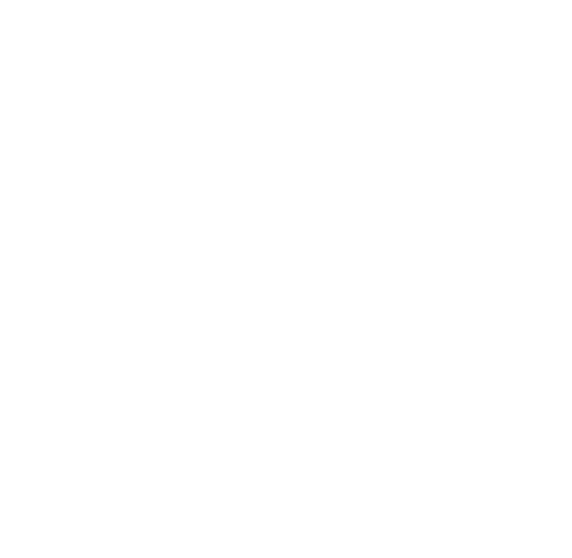

In [19]:
txt_file_rgb = os.path.join("/home/danielarato/ball_detection/Datasets/train/", "RGB_camera.txt")
f_rgb = open(txt_file_rgb, "r")
txt_result_rgb = open(os.path.join("/home/danielarato/ball_detection/Datasets/train/", "results_rgb.txt"),"w") 
centers_rgb=diameters_rgb=[]

_, ax = plt.subplots(figsize=(10, 10))
ax.axis('off')

for line_rgb in f_rgb: 
# READ IMAGES CORRESPONDENT TO EACH LINE
    im_rgb = cv2.imread(line_rgb[:84])
#     plt.imshow(im_rgb)
    outputs_rgb = predictor(im_rgb)


# GET BOUNDING BOXES
    results_rgb=outputs_rgb["instances"].to("cpu")
    
# UNCOMENT TO VISUALIZE IMAGES    
#     v_rgb = Visualizer(im_rgb[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
#     v_rgb = v_rgb.draw_instance_predictions(results_rgb)
#     plt.figure()
#     plt.imshow(v_rgb.get_image()[:, :, ::-1])
    
# CALCULATE CENTERS    
    if(len(results_rgb)!=0):
        coordinates_rgb=results_rgb.pred_boxes.tensor[0].numpy()
        xc_rgb=(coordinates_rgb[0]+coordinates_rgb[2])/2+coordinates_rgb[0]
        yc_rgb=(coordinates_rgb[3]+coordinates_rgb[1])/2+coordinates_rgb[1]
        xc_rgb=float("%0.2f"%xc_rgb)
        yc_rgb=float("%0.2f"%yc_rgb)
        centers_rgb.append([xc_rgb,yc_rgb])
        
        dx_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[2])-float("%0.2f"%coordinates_rgb[0])))
        dy_rgb=float("%0.2f"%(float("%0.2f"%coordinates_rgb[3])-float("%0.2f"%coordinates_rgb[1])))
        d_pix_rgb=(dx_rgb+dy_rgb)/2
        diameters_rgb.append([dx_rgb,dy_rgb]) 
        
        Z_rgb=((fx_rgb+fy_rgb)/2)*(d_real/d_pix_rgb)
        X_rgb=(Z_rgb*(xc_rgb-cx_rgb))/fx_rgb
        Y_rgb=(Z_rgb*(yc_rgb-cy_rgb))/fy_rgb
        
        
        txt_result_rgb.write(line_rgb[:88])
        txt_result_rgb.write(" , ")
        txt_result_rgb.write(np.array2string(coordinates_rgb))
        txt_result_rgb.write("\n")
        print(X_rgb/1000,Y_rgb/1000,Z_rgb/1000)
#         print("X1=",float("%0.2f"%coordinates[0]), " y1=",float("%0.2f"%coordinates[1])," x2=", float("%0.2f"%coordinates[2]), " y2=",float("%0.2f"%coordinates[3]),"Cx=",cx," Cy=",cy, " Dx=",dx," Dy=", dy)
txt_result_rgb.close()
f_rgb.close()

